# 其他

## 自动创建文件夹

In [2]:
import os
def mkfile(file):
    if not os.path.exists(file):
        os.makedirs(file)
save_path = "/home/huangjq/PyCharmCode/4_project/1_UNet/B4_attUnetv4/checkpoints/time/"
mkfile(save_path)

In [ ]:
def mkfile(file):
    if not os.path.exists(file):
        os.makedirs(file)

date = '0814'
dir_display = os.path.join('../results/display', date)
mkfile(dir_display)

## 保存图片

In [175]:
from PIL import Image
def mkfile(file):
    if not os.path.exists(file):
        os.makedirs(file)

date = '0814'
dir_images = os.path.join('../results/images', date)
dir_input = os.path.join(dir_images, 'input')
dir_output = os.path.join(dir_images, 'output')
dir_label = os.path.join(dir_images, 'label')
mkfile(dir_input)
mkfile(dir_output)
mkfile(dir_label)

X_test=Image.open('./1.jpeg')
output=Image.open('./2.jpeg')
y_test=Image.open('./3.jpeg')

X_test.save(os.path.join(dir_input, "name1.png"))
output.save(os.path.join(dir_output, "name2.png"))
y_test.save(os.path.join(dir_label, "name3.png"))

## Loss

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int,long)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

### 
https://blog.csdn.net/WYXHAHAHA123/article/details/88343945

In [168]:
import torch
import torch.nn.functional as F
import numpy as np
from torch.autograd import Variable
'''
pytorch实现focal loss的两种方式(现在讨论的是基于分割任务)
在计算损失函数的过程中考虑到类别不平衡的问题，假设加上背景类别共有6个类别
'''
def compute_class_weights(histogram):
    classWeights = np.ones(6, dtype=np.float32)
    normHist = histogram / np.sum(histogram)
    for i in range(6):
        classWeights[i] = 1 / (np.log(1.10 + normHist[i]))
    return classWeights
def focal_loss_my(input,target):
    '''
    :param input: shape [batch_size,num_classes,H,W] 仅仅经过卷积操作后的输出，并没有经过任何激活函数的作用
    :param target: shape [batch_size,H,W]
    :return:
    '''
    n, c, h, w = input.size()

    target = target.long()
    input = input.transpose(1, 2).transpose(2, 3).contiguous().view(-1, c)
    target = target.contiguous().view(-1)

    number_0 = torch.sum(target == 0).item()
    number_1 = torch.sum(target == 1).item()
    number_2 = torch.sum(target == 2).item()
    number_3 = torch.sum(target == 3).item()
    number_4 = torch.sum(target == 4).item()
    number_5 = torch.sum(target == 5).item()

    frequency = torch.tensor((number_0, number_1, number_2, number_3, number_4, number_5), dtype=torch.float32)
    frequency = frequency.numpy()
    classWeights = compute_class_weights(frequency)
    '''
    根据当前给出的ground truth label计算出每个类别所占据的权重
    '''

    # weights=torch.from_numpy(classWeights).float().cuda()
    weights = torch.from_numpy(classWeights).float()
    focal_frequency = F.nll_loss(F.softmax(input, dim=1), target, reduction='none')
    '''
    上面一篇博文讲过
    F.nll_loss(torch.log(F.softmax(inputs, dim=1)，target)的函数功能与F.cross_entropy相同
    可见F.nll_loss中实现了对于target的one-hot encoding编码功能，将其编码成与input shape相同的tensor
    然后与前面那一项（即F.nll_loss输入的第一项）进行 element-wise production
    相当于取出了 log(p_gt)即当前样本点被分类为正确类别的概率
    现在去掉取log的操作，相当于  focal_frequency  shape  [num_samples]
    即取出ground truth类别的概率数值，并取了负号
    '''

    focal_frequency += 1.0#shape  [num_samples]  1-P（gt_classes）

    focal_frequency = torch.pow(focal_frequency, 2)  # torch.Size([75])
    focal_frequency = focal_frequency.repeat(c, 1)
    '''
    进行repeat操作后，focal_frequency shape [num_classes,num_samples]
    '''
    focal_frequency = focal_frequency.transpose(1, 0)
    loss = F.nll_loss(focal_frequency * (torch.log(F.softmax(input, dim=1))), target, weight=None,
                      reduction='elementwise_mean')
    return loss


def focal_loss_zhihu(input, target):
    '''
    :param input: 使用知乎上面大神给出的方案  https://zhuanlan.zhihu.com/p/28527749
    :param target:
    :return:
    '''
    n, c, h, w = input.size()

    target = target.long()
    inputs = input.transpose(1, 2).transpose(2, 3).contiguous().view(-1, c)
    target = target.contiguous().view(-1)

    N = inputs.size(0)
    C = inputs.size(1)

    number_0 = torch.sum(target == 0).item()
    number_1 = torch.sum(target == 1).item()
    number_2 = torch.sum(target == 2).item()
    number_3 = torch.sum(target == 3).item()
    number_4 = torch.sum(target == 4).item()
    number_5 = torch.sum(target == 5).item()

    frequency = torch.tensor((number_0, number_1, number_2, number_3, number_4, number_5), dtype=torch.float32)
    frequency = frequency.numpy()
    classWeights = compute_class_weights(frequency)

    weights = torch.from_numpy(classWeights).float()
    weights=weights[target.view(-1)]#这行代码非常重要

    gamma = 2

    P = F.softmax(inputs, dim=1)#shape [num_samples,num_classes]

    class_mask = inputs.data.new(N, C).fill_(0)
    class_mask = Variable(class_mask)
    ids = target.view(-1, 1)
    class_mask.scatter_(1, ids.data, 1.)#shape [num_samples,num_classes]  one-hot encoding

    probs = (P * class_mask).sum(1).view(-1, 1)#shape [num_samples,]
    log_p = probs.log()

    print('in calculating batch_loss',weights.shape,probs.shape,log_p.shape)

    # batch_loss = -weights * (torch.pow((1 - probs), gamma)) * log_p
    batch_loss = -(torch.pow((1 - probs), gamma)) * log_p

    print(batch_loss.shape)

    loss = batch_loss.mean()
    return loss

if __name__=='__main__':
#     pred=torch.rand((2,6,5,5))
    pred=torch.rand((1,6,5,5))
#     y=torch.from_numpy(np.random.randint(0,6,(2,5,5)))
    y=torch.from_numpy(np.random.randint(0,6,(1,5,5)))
    
    loss1=focal_loss_my(pred,y)
    loss2=focal_loss_zhihu(pred,y)
    
    print(pred.shape)
    print(y.shape)
    print('loss1',loss1)
    print('loss2', loss2)
    
'''
in calculating batch_loss torch.Size([50]) torch.Size([50, 1]) torch.Size([50, 1])
torch.Size([50, 1])
loss1 tensor(1.3166)
loss2 tensor(1.3166)
'''

in calculating batch_loss torch.Size([25]) torch.Size([25, 1]) torch.Size([25, 1])
torch.Size([25, 1])
torch.Size([1, 6, 5, 5])
torch.Size([1, 5, 5])
loss1 tensor(1.3302)
loss2 tensor(1.3302)


'\nin calculating batch_loss torch.Size([50]) torch.Size([50, 1]) torch.Size([50, 1])\ntorch.Size([50, 1])\nloss1 tensor(1.3166)\nloss2 tensor(1.3166)\n'

## 数据集加载
dataset的时候不做操作，在dataloader的时候操作

### 数据增强

#### 方法一
参考链接：https://blog.csdn.net/qq_37424778/article/details/107407209

Compose(
    RandomHorizontalFlip(p=0)
    RandomVerticalFlip(p=0)
    RandomRotation(degrees=(30, 60), resample=False, expand=False)
    Resize(size=360, interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(320, 320))
)


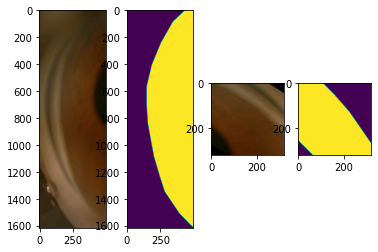

In [94]:

from PIL import Image
import torchvision.transforms as transforms
from torchvision import transforms
import matplotlib.pyplot as plt
import random
import numpy as np

seed = np.random.randint(2147483647)     # make a seed with numpy generator
random.seed(seed) 

p1 = random.randint(0,1)
p2 = random.randint(0,1)

train_img_transform =transforms.Compose([
    transforms.RandomHorizontalFlip(p1),
    transforms.RandomVerticalFlip(p2), 
    transforms.RandomRotation((30, 60), resample=False, expand=False, center=None),
#     transforms.RandomResizedCrop(320),
    transforms.Resize(360, interpolation=2),
    transforms.CenterCrop(320),
#     transforms.RandomCrop(320, padding=0, pad_if_needed=False)
#     transforms.ToTensor(), 
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_label_transform =transforms.Compose([
    transforms.RandomHorizontalFlip(p1),
    transforms.RandomVerticalFlip(p2), 
    transforms.RandomRotation((30, 60), resample=False, expand=False, center=None),
#     transforms.RandomResizedCrop(320),
    transforms.Resize(360, interpolation=2),
    transforms.CenterCrop(320),
#     transforms.RandomCrop(320, padding=0, pad_if_needed=False)
#     transforms.ToTensor(), 
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
print(preprocess)

img = '/home/huangjq/PyCharmCode/1_dataset/1_glaucoma/v6.1/segmentation_data/image_data/test/067-RN.JPG'
mask = '/home/huangjq/PyCharmCode/1_dataset/1_glaucoma/v6.1/segmentation_data/label_data/test/067-RN.JPG'
img = Image.open(img)
mask = Image.open(mask)

img1 = train_img_transform(img)
mask1 = train_label_transform(mask)

plt.figure()
plt.subplot(1,4,1)
plt.imshow(img)
plt.subplot(1,4,2)
plt.imshow(mask)
plt.subplot(1,4,3)
plt.imshow(img1)
plt.subplot(1,4,4)
plt.imshow(mask1)
plt.show()

# plt.figure()

# plt.imshow(img)
# plt.show()

# for i in range(5):
#     random.seed(seed)                    # apply this seed to img tranfsorms
#     f = plt.imshow(preprocess(im))


#### 方法二
参考链接：https://blog.csdn.net/happyeveryday62/article/details/104350332

0.5282780875054263


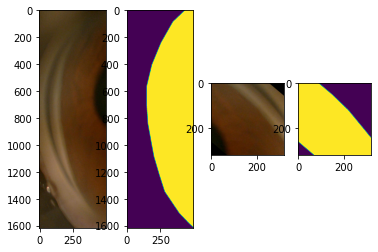

In [133]:
import random
import cv2
from torchvision import transforms
import torchvision.transforms.functional as tf
from PIL import Image

def transform1(image, mask):
    # 1) 50%的概率应用垂直，水平翻转。
    p = random.random()
    print(p)
    if p > 0.5:
        image = tf.hflip(image)
        mask = tf.hflip(mask)
    else:
        image = tf.vflip(image)
        mask = tf.vflip(mask)
        
    # 2) 拿到角度的随机数。angle是一个-180到180之间的一个数
    angle = transforms.RandomRotation.get_params([30, 60])
    # 对image和mask做相同的旋转操作，保证他们都旋转angle角度
    image = image.rotate(angle)
    mask = mask.rotate(angle)
    
    return image, mask

transform2 =transforms.Compose([
    transforms.Resize(360, interpolation=2),
    transforms.CenterCrop(320),
#     transforms.ToTensor(), 
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


# transform处理对象一般都是 PIL Image

img = '/home/huangjq/PyCharmCode/1_dataset/1_glaucoma/v6.1/segmentation_data/image_data/test/067-RN.JPG'
mask = '/home/huangjq/PyCharmCode/1_dataset/1_glaucoma/v6.1/segmentation_data/label_data/test/067-RN.JPG'
img = Image.open(img)
mask = Image.open(mask)

img1, mask1 = transform1(img, mask)
img2, mask2 = transform2(img1), transform2(mask1)

# plt.figure()
# plt.subplot(1,4,1)
# plt.imshow(img)
# plt.subplot(1,4,2)
# plt.imshow(mask)
# plt.subplot(1,4,3)
# plt.imshow(img1)
# plt.subplot(1,4,4)
# plt.imshow(mask1)
# plt.show()

plt.figure()
plt.subplot(1,4,1)
plt.imshow(img)
plt.subplot(1,4,2)
plt.imshow(mask)
plt.subplot(1,4,3)
plt.imshow(img2)
plt.subplot(1,4,4)
plt.imshow(mask2)
plt.show()

### 数据增强
参考链接：https://cloud.tencent.com/developer/article/1435013

('104-LI.JPG', '114-RT.JPG', '133-RI.JPG', '053-RS.JPG', '130-LS.JPG')
torch.Size([5, 3, 320, 320])


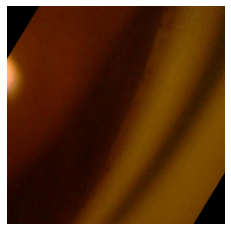

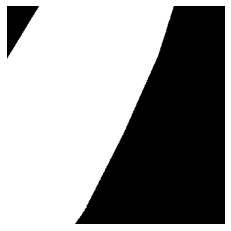

('105-RI.JPG', '011-RT.JPG', '053-RT2.JPG', '062-LI.JPG', '061-LS1.JPG')
torch.Size([5, 3, 320, 320])


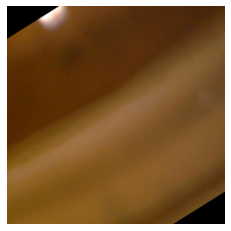

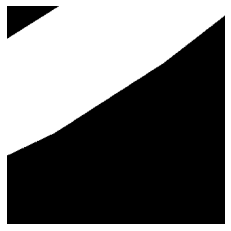

In [158]:
import torch.utils.data as DATA
from PIL import Image
import torchvision.transforms as transforms
import os
import torch

def labeltensor_to_PIL(tensor):
    """
    这个用于标签图展示：将tensor转为黑白图片
    :param tensor: [batch=1, c ,h w]
    :return:
    """
    unloader = transforms.ToPILImage()
    image = tensor[0].cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    image = image.convert('1')
    return image

def imgtensor2im(input_image, imtype=np.uint8):
    """
    这个用于原图展示：将tensor转为原始的图片
    :param input_image:
    :param imtype:
    :return:
    """
    if isinstance(input_image, torch.Tensor):
        image_tensor = input_image.data
    else:
        return input_image
    image_numpy = image_tensor[0].cpu().float().numpy()
    if image_numpy.shape[0] == 1:
        image_numpy = np.tile(image_numpy, (3, 1, 1))
    image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0
    return image_numpy.astype(imtype)



transform2 =transforms.Compose([
    transforms.Resize(360, interpolation=2),
    transforms.CenterCrop(320),
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform3 =transforms.Compose([
    transforms.Resize(360, interpolation=2),
    transforms.CenterCrop(320),
    transforms.ToTensor(), 
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

def transform1(image, mask):
    # 1) 50%的概率应用垂直，水平翻转。
    p = random.random()
    if p > 0.5:
        image = tf.hflip(image)
        mask = tf.hflip(mask)
    else:
        image = tf.vflip(image)
        mask = tf.vflip(mask)
        
    # 2) 拿到角度的随机数。angle是一个-180到180之间的一个数
    angle = transforms.RandomRotation.get_params([30, 60])
    # 对image和mask做相同的旋转操作，保证他们都旋转angle角度
    image = image.rotate(angle)
    mask = mask.rotate(angle)
    
    return image, mask

class Glaucoma_Dataset(DATA.Dataset):
    def __init__(self, root, phase):
        '''
        目标：获取所有图片地址，并根据训练、验证、测试集划分数据
        '''
        super(Glaucoma_Dataset, self).__init__()

        self.root = root
        self.phase = phase

        self.dir_img = os.path.join(self.root, 'image_data')  # 训练图像文件
        self.dir_label = os.path.join(self.root, 'label_data')  # 图像的结果文件夹
        
        self.dir_img = os.path.join(self.dir_img, self.phase)  # 训练图像文件
        self.dir_label = os.path.join(self.dir_label, self.phase)  # 图像的结果文件夹

        # image
        self.imgs = os.listdir(self.dir_img)  # 输出的是[文件名]，包含.jpg——用于训练的原图
        self.img = [os.path.join(self.dir_img, s) for s in self.imgs]  # `os.path.join`是将两个路径名字粘贴在一起
        # label
        self.label = [os.path.join(self.dir_label, ss) for ss in self.imgs]
        
        self.name = self.imgs

    def __getitem__(self, index):
        '''
        返回一张图片的数据
        '''
        img, label, name= self.img[index], self.label[index], self.name[index]  # 此时的img，label只是对应图片的路径，还没有打开文件
        # 打开图片
        img = Image.open(img)
        label = Image.open(label)
        
        if self.phase == 'train':
            img_1, label_1 = transform1(img, label)
            img= transform2(img_1)
            label = transform3(label_1)
        else:
            img= transform2(img)
            label = transform3(label)

        return img, label, name

    def __len__(self):
        '''
        返回数据集中所有的的图片个数
        '''
        return len(self.img)


data_path_train = '/home/huangjq/PyCharmCode/1_dataset/1_glaucoma/v6.1/segmentation_data'

dataset = Glaucoma_Dataset(data_path_train, 'train')
batch_size = 5
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = DATA.sampler.SubsetRandomSampler(train_indices)
valid_sampler = DATA.sampler.SubsetRandomSampler(val_indices)

train_loader = DATA.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = DATA.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

# Usage Example:
num_epochs = 1
for epoch in range(num_epochs):
    # Train:   
    for batch_index, (imgs, labels, name) in enumerate(train_loader):
        print(name)     # ('114-LI1.JPG', '032-RT.JPG', '061-RI3.JPG', '020-LS.JPG', '067-RS.JPG')
        print(imgs.shape)
        imgs = imgtensor2im(imgs)
        plt.imshow(imgs) # 显示图片
        plt.axis('off') # 不显示坐标轴
        plt.show()
        
        labels = labeltensor_to_PIL(labels)
        plt.imshow(labels) # 显示图片
        plt.axis('off') # 不显示坐标轴
        plt.show()
        
        break
    for batch_index, (imgs, labels, name) in enumerate(train_loader):
        print(name)     # ('114-LI1.JPG', '032-RT.JPG', '061-RI3.JPG', '020-LS.JPG', '067-RS.JPG')
        print(imgs.shape)
        imgs = imgtensor2im(imgs)
        plt.imshow(imgs) # 显示图片
        plt.axis('off') # 不显示坐标轴
        plt.show()
        
        labels = labeltensor_to_PIL(labels)
        plt.imshow(labels) # 显示图片
        plt.axis('off') # 不显示坐标轴
        plt.show()
        
        break
         
# train_size = int(0.8 * len(full_dataset))
# test_size = len(full_dataset) - train_size
# train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])